In [11]:
import glob
import random
from tqdm import tqdm_notebook

import numpy as np
import cv2
import keras

import matplotlib.pyplot as plt
%matplotlib inline

Load Data

In [2]:
DATASET_DIR = "./data"

IMG_PATHS = glob.glob(DATASET_DIR+"/*.jpg")
IMG_PATHS.sort()

print("Number of images:\t", len(IMG_PATHS))
print("Path to first image:\t", IMG_PATHS[0])
print("Path to last image:\t", IMG_PATHS[-1])

Number of images:	 2818
Path to first image:	 ./data/2019012900000000.jpg
Path to last image:	 ./data/2019020719050000.jpg


Showing 9 random images


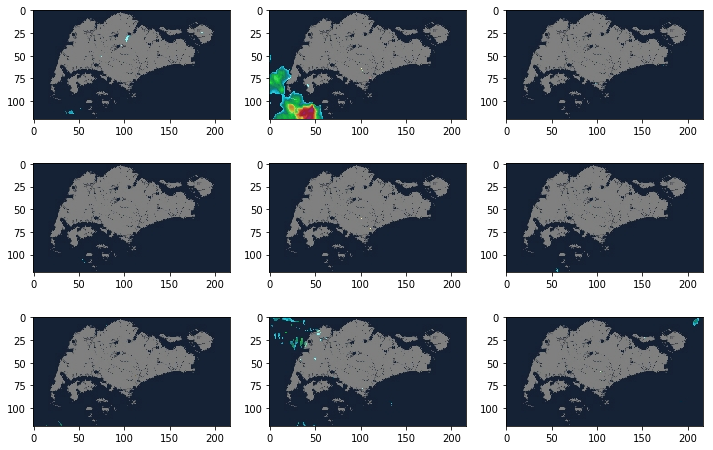

In [7]:
num_images = len(IMG_PATHS)

print("Showing 9 random images")

plt.figure(1, figsize=(12,8))

for i in range(9):
    n = random.randint(0, num_images-1)
    plt.subplot(3,3,i+1)
    image = cv2.imread(IMG_PATHS[n])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
plt.show()


Showing 9 random images after scaling


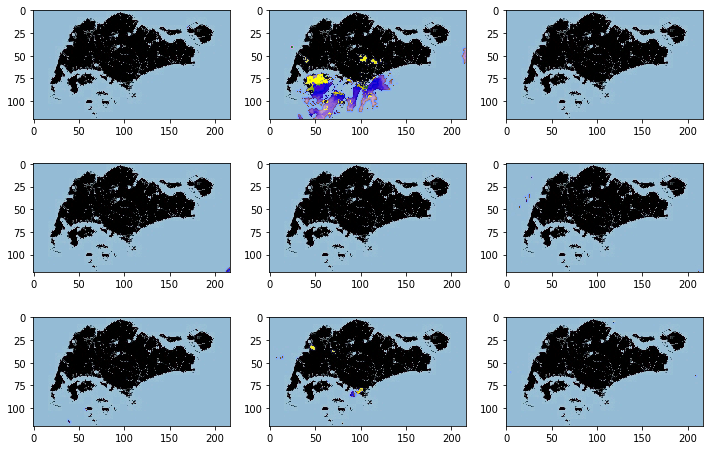

In [13]:
images_loaded = []

for image_path in tqdm_notebook(IMG_PATHS):
    image = cv2.imread(image_path)
    # scale image to range -1 to +1
    image = image/127.5 - 1.0
    images_loaded.append(image)
    
num_images = len(IMG_PATHS)

print("Showing 9 random images after scaling")

plt.figure(1, figsize=(12,8))

for i in range(9):
    n = random.randint(0, num_images-1)
    plt.subplot(3,3,i+1)
    # only use absolute to show image, when input, data is -1 to +1
    image = np.absolute(images_loaded[n])
    plt.imshow(image)
    
plt.show()

In [8]:
def data_generator(batch_size, sequence_length, images):
    num_images = len(images)
    sequence_length_ = sequence_length + 1
    sequence_length_2 = sequence_length_ * 2
    
    image_range = num_images+1-sequence_length_2
    batch_in, batch_out = [], []
    
    while True:
        for i in range(image_range):
            sequence_in = [images[i+j] for j in range(0, sequence_length_)]
            sequence_out = [images[i+k] for k in range(sequence_length_, sequence_length_2)]
            batch_in.append(sequence_in)
            batch_out.append(sequence_out)
            if len(batch_in) >= batch_size:
                batch_in_ = np.asarray(batch_in)
                batch_out_ = np.asarray(batch_out)
                yield [[batch_in_], [batch_out_]]
                batch_in, batch_out = [], []